<a href="https://colab.research.google.com/github/vblancoOR/econometria/blob/main/Autocorrelacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd #librería para manejo de datos

import numpy as np

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

# Load the dataset into a pandas DataFrame
datos = pd.read_csv(url)
# Combine year, month, day, and hour into a single datetime column
datos['datetime'] = pd.to_datetime(datos[['year', 'month', 'day', 'hour']])
# Set datetime as the index and drop original columns
datos.set_index('datetime', inplace=True)

# Drop unnecessary columns for simplicity
datos = datos[['pm2.5', 'TEMP', 'PRES', 'Iws']].dropna()
# Display the first few rows of the DataFrame
datos



,pm2.5,TEMP,PRES,Iws
datetime,,,,
2010-01-02 00:00:00,129.0,-4.0,1020.0,1.79
2010-01-02 01:00:00,148.0,-4.0,1020.0,2.68
2010-01-02 02:00:00,159.0,-5.0,1021.0,3.57
2010-01-02 03:00:00,181.0,-5.0,1022.0,5.36
2010-01-02 04:00:00,138.0,-5.0,1022.0,6.25
...,...,...,...,...
2014-12-31 19:00:00,8.0,-2.0,1034.0,231.97
2014-12-31 20:00:00,10.0,-3.0,1034.0,237.78
2014-12-31 21:00:00,10.0,-3.0,1034.0,242.70


In [3]:

import statsmodels.api as sm

y=datos["pm2.5"]
X=datos[['TEMP', 'PRES', 'Iws']]

mco = sm.OLS(y, sm.add_constant(X)).fit()
print(mco.summary())


                            OLS Regression Results                            
Dep. Variable:                  pm2.5   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     1807.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:48:24   Log-Likelihood:            -2.4554e+05
No. Observations:               41757   AIC:                         4.911e+05
Df Residuals:                   41753   BIC:                         4.911e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3263.7306     75.351     43.313      0.0

Gráficos

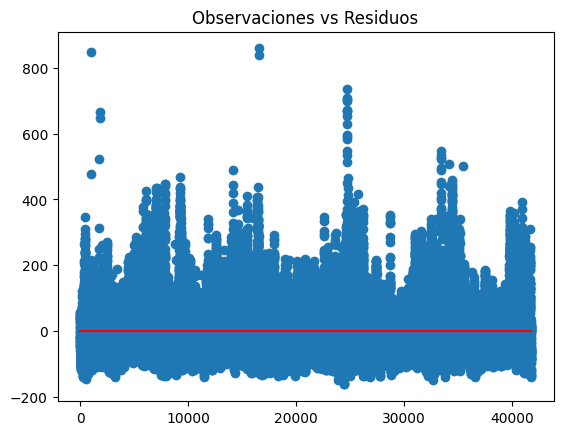

In [4]:
import matplotlib.pylab as plt

plt.scatter(list(range(int(mco.nobs))), mco.resid)
plt.plot([-1,mco.nobs+1], [0,0], color='r')
plt.title("Observaciones vs Residuos")
plt.show()


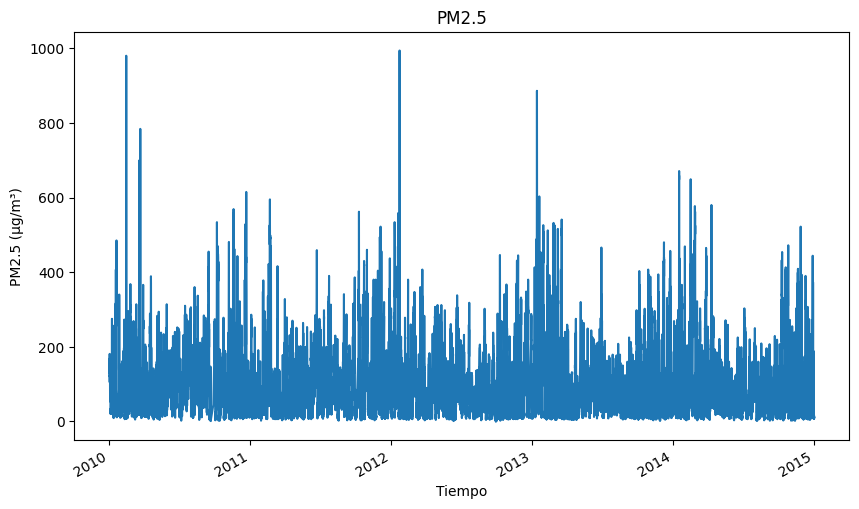

In [2]:
import matplotlib.pyplot as plt

# Plot PM2.5 over time
datos['pm2.5'].plot(figsize=(10, 6), title='PM2.5')
plt.xlabel('Tiempo')
plt.ylabel('PM2.5 (µg/m³)')
plt.show()

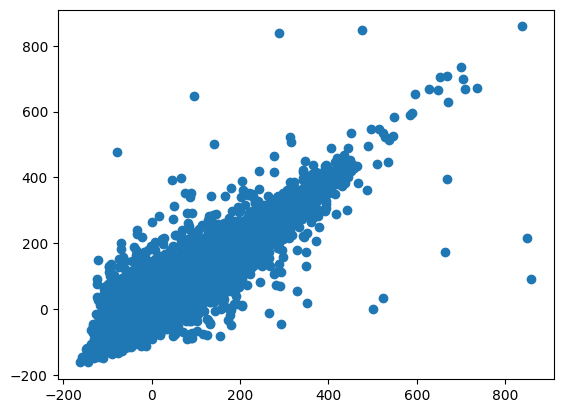

In [11]:
retardo=1
residuos = mco.resid[retardo:]
residuos_retardados=mco.resid[:-retardo]

plt.scatter(residuos, residuos_retardados)
plt.show()

Durbin-Watson

In [13]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(mco.resid)
print("Durbin-Watson statistic:", dw)

Durbin-Watson statistic: 0.0871118959776711


H_Durbin

In [14]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

# Simulated example: Autoregressive data
np.random.seed(0)
n = 100
y_original = datos["pm2.5"]
y_retardada = np.roll(y_original, 1)  #
y_retardada[0] = 0  #


modelo = sm.OLS(y_original, sm.add_constant(y_retardada)).fit()

# Extract parameters
beta = modelo.params["x1"]  # Coeficiente
var_beta = modelo.bse["x1"] ** 2  # Variance del coeficiente

# Compute Durbin's h statistic
h = (1 - dw / 2) * np.sqrt(n / (1 - var_beta))


print("h-Durbin:", h)

# Check significance of h
if np.abs(h) > 1.96:  # Rough 95% confidence interval
    print("Autocorrelation detectada.")
else:
    print("Autocorrelation no significativa.")


h-Durbin: 9.5644485108397
Autocorrelation detectada.


Ljung-Box

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox


acorr_ljungbox(mco.resid, lags=5)


,lb_stat,lb_pvalue
1,38201.311659,0.0
2,72123.312010,0.0
3,102303.079093,0.0
4,129206.660518,0.0
5,153191.868629,0.0


Corrección: Cochran-Orcutt

In [16]:
rho= 1 - dw/2 # dw = 2(1-rho) => rho = 1 - DW/2
print(rho)
mco_autocorr=sm.GLSAR(y, sm.add_constant(X), rho=rho)
res=mco_autocorr.iterative_fit(maxiter=100,rtol=10**(-10))


print ('Iteraciones = %d -->  Converge: %s' % (res.iter, res.converged) )
print ('Rho =  ', mco_autocorr.rho)
print(res.summary())

0.9564440520111644
Iteraciones = 6 -->  Converge: True
Rho =   [0.96308132]
                           GLSAR Regression Results                           
Dep. Variable:                  pm2.5   R-squared:                       0.008
Model:                          GLSAR   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     105.6
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           4.27e-68
Time:                        19:07:40   Log-Likelihood:            -1.9232e+05
No. Observations:               41756   AIC:                         3.847e+05
Df Residuals:                   41752   BIC:                         3.847e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [ ]:
pd.datos["TEMP"].

In [ ]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

#calculate CV for each column in data frame
datos.apply(cv)

,0
pm2.5,93.344880
TEMP,98.174858
PRES,1.013410
Iws,207.893830


In [20]:
import statsmodels.stats.diagnostic as diag
diag.kstest_normal(mco.resid)

(0.11289822906657282, 0.0009999999999998899)